# Begining of Life

The purpose of this notebook is to establish basic beginning of life parameters of this concept including $k_{eff}$ and neutron energy spectrum.

In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

In [2]:
fuel = openmc.Material(name="uo2")
fuel.add_element("U", 1, percent_type="ao", enrichment=15.5)
fuel.add_element("O", 2)
fuel.set_density("g/cc", 10.5)

clad = openmc.Material(name='clad');
clad.add_element("Zr",1);
clad.set_density('g/cc',6.0);

water = openmc.Material(name='water');
water.add_element('O',1);
water.add_element('H',2)
water.set_density('g/cc',0.712); # high temperature density
water.add_s_alpha_beta('c_H_in_H2O');

materials = openmc.Materials([fuel,clad,water]);

/home/sblair/miniconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/material.py:566: UserWarning: A uranium enrichment of 15.5 was given for Material ID="1". OpenMC assumes the U234/U235 mass ratio is constant at 0.008, which is only valid at low enrichments. Consider setting the isotopic composition manually for enrichments over 5%.
  warnings.warn(msg)


## Pin Cell Geometry

The goal is to establish a pin-cell to provide a simplified representation of the basic criticality and (especially) neutron energy spectrum for this concept.  

In [3]:
h_core = 300.; 
h_fuel = 200.;

r_fuel = 0.42;
r_pin = 0.45;

P_D = 1.15;

pitch = P_D*(2*r_pin);

fuel_temp = 900; # K, representative fuel temperature
mod_temp = 600; # K, representative moderator temperature

# fuel cylinder:
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_fuel;

# pin cylinder
pin_cyl = openmc.model.RightCircularCylinder([0.,0.,-(h_fuel+(r_pin-r_fuel))/2.],
                                            h_fuel+(r_pin-r_fuel)*2.,r_pin);

# pin cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;


clad_cell = openmc.Cell();
clad_cell.region = +fuel_cyl & -pin_cyl;
clad_cell.fill = clad;

mod_cell = openmc.Cell();
mod_cell.region = +pin_cyl & -core_cell;
mod_cell.fill = water

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,clad_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;



materials.export_to_xml();
geometry.export_to_xml();

colors = {} #empty dictionary to hold color assignments by material
colors[fuel] = 'yellow'
colors[water] = 'blue'
colors[clad] = 'grey'


In [4]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_fuel/2.),
                      upper_right = (r_fuel,r_fuel,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;

settings.temperature['method']='interpolation';

settings.export_to_xml();

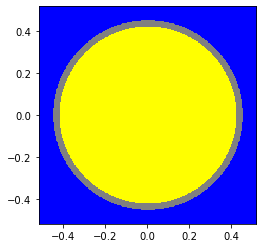

In [5]:
root_univ.plot(width=(pitch,pitch),pixels=[400,400],color_by='material',colors=colors);

In [6]:
# get flux energy spectrum in the fuel

# filter for the fuel cell
cell_filter = openmc.CellFilter(fuel_cell)

# set up energy bins
N = 1001
energy_bins = np.logspace(-3,7,num=N)
energy_filter = openmc.EnergyFilter(values=energy_bins)

# establish flux tally
flux = openmc.Tally(name='flux')
flux.scores = ['flux']
flux.filters = [cell_filter,energy_filter]

tallies = openmc.Tallies([flux])

tallies.export_to_xml()


In [7]:
openmc.run();

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      137/1    1.40007    1.38190 +/- 0.00121
      138/1    1.36961    1.38176 +/- 0.00120
      139/1    1.39138    1.38187 +/- 0.00120
      140/1    1.37934    1.38184 +/- 0.00118
      141/1    1.38536    1.38188 +/- 0.00117
      142/1    1.38559    1.38192 +/- 0.00116
      143/1    1.39514    1.38206 +/- 0.00115
      144/1    1.39489    1.38220 +/- 0.00115
      145/1    1.40269    1.38241 +/- 0.00116
      146/1    1.38458    1.38244 +/- 0.00115
      147/1    1.36207    1.38223 +/- 0.00115
      148/1    1.37276    1.38213 +/- 0.00115
      149/1    1.37894    1.38210 +/- 0.00113
      150/1    1.39276    1.38220 +/- 0.00113
      151/1    1.36942    1.38208 +/- 0.00112
      152/1    1.39695    1.38222 +/- 0.00112
      153/1    1.38440    1.38224 +/- 0.00111
      154/1    1.36023    1.38203 +/- 0.00112
      155/1    1.38397    1.38205 +/- 0.00111
      156/1    1.37440    1.38198 +/- 0.00110
      157/1    1.38245    1.38198 +/- 0.00109
      158/1    1.38845    1.38204 

Text(0, 0.5, 'flux [n/cm**2-s]')

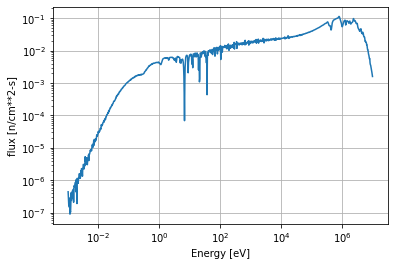

In [8]:
sp = openmc.StatePoint('statepoint.200.h5')
sp.tallies

flux_t = sp.get_tally(name='flux')
flux_df = flux_t.get_pandas_dataframe()
flux_vals = flux_df['mean'].to_numpy()

energy_x = 0.5*(energy_bins[0:-1]+energy_bins[1:])

plt.loglog(energy_x,flux_vals)
plt.grid()
plt.xlabel('Energy [eV]')
plt.ylabel('flux [n/cm**2-s]')